In [2]:
# 파일 연동하는 법
# 1. 매니저님이 공유해주신 드라이브 공유 폴더를 내 드라이브에 바로가기 생성(https://sundries-in-myidea.tistory.com/96 참고)
# 2. 드라이브 마운트(밑에 코드 실행하면 됨)
# 3. 새로고침 후 제대로 되었는지 확인
# 본인에게는 전체 드라이브 내용이 보이지만 다른사람에게는 보이지 않으므로 걱정하지 않으셔도 됩니다

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# kaggle “Predict Future Sales” competition
https://www.kaggle.com/c/competitive-data-science-predict-future-sales

-  2013년 1월부터 2015년 10월까지의 각 매장 및 상품 판매 이력을 통해 2015년 11월 상품 판매량을 예측
- 이는 각 매장의 상품 재고 관리에 도움을 줄 것으로 예상 

# -------------------------------------사전 준비-------------------------------------------

In [87]:
# 라이브러리 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import folium
from sklearn.preprocessing import LabelEncoder

In [152]:
# 데이터 불러오기
df_train = pd.read_csv('/content/drive/MyDrive/Predict_future_sales/data/sales_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Predict_future_sales/data/test.csv')
df_items = pd.read_csv('/content/drive/MyDrive/Predict_future_sales/data/items.csv')
df_item_categories = pd.read_csv('/content/drive/MyDrive/Predict_future_sales/data/item_categories.csv')
df_shops = pd.read_csv('/content/drive/MyDrive/Predict_future_sales/data/shops.csv')

In [89]:
# 데이터프레임 출력 옵션 설정(보기 편하도록)
# pd.reset_option('display.width')
# pd.reset_option('display.max_rows')
pd.set_option('display.max_columns', 20)
# pd.reset_option('display.max_colwidth')
# pd.reset_option('display.unicode.ambiguous_as_wide')

In [90]:
# 데이터 첫 3행 확인
print(f'df_train \n {df_train.head(3)} \n')
print(f'df_test \n {df_test.head(3)} \n')
print(f'df_items \n {df_items.head(3)} \n')
print(f'df_item_categories \n {df_item_categories.head(3)} \n')
print(f'df_shops \n {df_shops.head(3)} \n')

df_train 
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154       999.0           1.0
1  03.01.2013               0       25     2552       899.0           1.0
2  05.01.2013               0       25     2552       899.0          -1.0 

df_test 
    ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233 

df_items 
                                            item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40   

df_item_categories 
         item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2 

df_shops 
        

In [91]:
# train, test 데이터 요약 정보 확인
print('df_train information')
print(df_train.info(), '\n')
print('df_test information')
print(df_test.info(), '\n')
print('df_items information')
print(df_items.info(), '\n')
print('df_item_categories information')
print(df_item_categories.info(), '\n')
print('df_shops information')
print(df_shops.info(), '\n')
# 결측치가 존재할 가능성이 있는 데이터는 df_train 뿐

df_train information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None 

df_test information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None 

df_items information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            ------

In [92]:
# df_train 통계량 정보 확인(나머지는 확인할 필요성 없음)
print('df_train information')
print(df_train.describe(include='all'), '\n')
# item_price는 음수가 존재할 수 없는데 존재 > 이상치 확인
# item_cnt_day 역시 음수가 존재할 수 없는데 존재 > 이상치 확인

df_train information
              date  date_block_num       shop_id       item_id    item_price  \
count      2935849    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06   
unique        1034             NaN           NaN           NaN           NaN   
top     28.12.2013             NaN           NaN           NaN           NaN   
freq          9434             NaN           NaN           NaN           NaN   
mean           NaN    1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02   
std            NaN    9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03   
min            NaN    0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00   
25%            NaN    7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02   
50%            NaN    1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02   
75%            NaN    2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02   
max            NaN    3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05   

        item_cnt_d

# ---------------------------------중복값 확인 및 처리-------------------------------------------------

In [93]:
# 중복값 확인
print(f'df_train의 중복 개수 : {df_train.duplicated().sum()}')
print(f'df_test의 중복 개수 : {df_test.duplicated().sum()}')
print(f'df_items의 중복 개수 : {df_items.duplicated().sum()}')
print(f'df_item_categories의 중복 개수 : {df_item_categories.duplicated().sum()}')
print(f'df_shops의 중복 개수 : {df_shops.duplicated().sum()}')
# df_train에만 값이 중복되는 행이 존재, 하지만 같은 매장, 같은 물건이 판매된것으로 판단 > 처리할 것 없음

df_train의 중복 개수 : 6
df_test의 중복 개수 : 0
df_items의 중복 개수 : 0
df_item_categories의 중복 개수 : 0
df_shops의 중복 개수 : 0


In [94]:
# # 중복값 제거
# print(len(df_train))
# df_train.drop_duplicates(inplace=True)
# print(len(df_train))
# # 중복된 6개 행 제거 확인

# ---------------------------------결측값 확인 및 처리-------------------------------------------------

In [95]:
# 결측치 확인
# df_train만 확인하면 됨
df_train.isnull().sum()
# 결측치 없음

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

# ---------------------------------이상값 확인 및 처리-------------------------------------------------

307980.0/-1.0


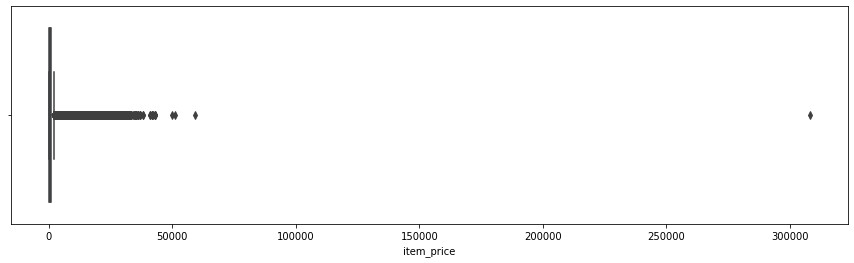

In [153]:
# 이상치 확인(1) - df_train.item_price
plt.figure(figsize=(15,4))
sns.boxplot(x=df_train.item_price)
print(df_train.item_price.max(), df_train.item_price.min(), sep='/')

In [154]:
# 이상치로 예상되는 데이터 확인
df_train[(df_train.item_price>40000) | (df_train.item_price<0)]
# 40000 대는 단순히 가격대가 높은 물건으로 판단
# 이상치의 기준을 49000으로 판단

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0
885138,17.09.2013,8,12,11365,59200.0,1.0
1006638,24.10.2013,9,12,7238,42000.0,1.0
1163158,13.12.2013,11,12,6066,307980.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0
2143903,20.11.2014,22,12,14173,40900.0,1.0
2327159,29.01.2015,24,12,7241,49782.0,1.0
2885692,23.10.2015,33,42,13403,42990.0,1.0
2893100,20.10.2015,33,38,13403,41990.0,1.0
2910155,20.10.2015,33,12,13403,41990.0,1.0


In [155]:
# 이상치 확인(1-1) - item_price가 -1인 경우의 item이 무엇인지 확인
df_items[df_items.item_id==2973]

,item_name,item_id,item_category_id
2973,"DmC Devil May Cry [PS3, русские субтитры]",2973,19


In [156]:
# 해당 상품 가격 확인
df_train[df_train.item_id==2973]
# 일정하지 않음 > 비슷한 날짜의 가격 확인

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352,15.01.2013,0,25,2973,2499.00,13.0
353,16.01.2013,0,25,2973,2499.00,5.0
354,17.01.2013,0,25,2973,2499.00,3.0
355,18.01.2013,0,25,2973,2499.00,2.0
356,19.01.2013,0,25,2973,2499.00,3.0
...,...,...,...,...,...,...
1765321,22.06.2014,17,57,2973,1249.50,1.0
1782298,09.06.2014,17,47,2973,1249.00,1.0
1851765,04.07.2014,18,26,2973,1249.50,1.0
1923837,06.08.2014,19,6,2973,1249.50,1.0


In [157]:
# df_train의 date 자료형을 datetime으로 변경
df_train.date = df_train.date.apply(lambda x:x.replace('.','/'))
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02/01/2013,0,59,22154,999.00,1.0
1,03/01/2013,0,25,2552,899.00,1.0
2,05/01/2013,0,25,2552,899.00,-1.0
3,06/01/2013,0,25,2554,1709.05,1.0
4,15/01/2013,0,25,2555,1099.00,1.0


In [158]:
df_train.date = pd.to_datetime(df_train.date, format='%d/%m/%Y')
print(df_train.date.dtypes)
df_train.head()

datetime64[ns]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [159]:
# 2013년 5월 10일부터 같은 아이템의 10개 데이터 확인
df_train[(df_train.date.dt.year==2013)&(df_train.date.dt.month==5)&(df_train.date.dt.day>10)&(df_train.item_id==2973)].sort_values(by='date').head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
486054,2013-05-11,4,54,2973,2499.0,1.0
446461,2013-05-13,4,29,2973,1249.0,1.0
480577,2013-05-14,4,35,2973,1249.5,1.0
521031,2013-05-14,4,43,2973,1249.0,1.0
473481,2013-05-14,4,42,2973,1249.0,1.0
463473,2013-05-14,4,41,2973,1249.0,1.0
453035,2013-05-14,4,25,2973,1249.1,2.0
456795,2013-05-14,4,21,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0


In [160]:
# 이상치 처리(1-1) - 1249로 예상되므로 -1을 1249로 수정
print(f'변경 전 : {df_train.loc[484683,"item_price"]}')
df_train.loc[484683,'item_price']=1249.0
print(f'변경 후 : {df_train.loc[484683,"item_price"]}')

변경 전 : -1.0
변경 후 : 1249.0


In [161]:
# 이상치 확인(1-2) - item_price가 49000보다 높은 경우 확인
df_train[df_train.item_price>49000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,2013-09-17,8,12,11365,59200.0,1.0
1163158,2013-12-13,11,12,6066,307980.0,1.0
1488135,2014-03-20,14,25,13199,50999.0,1.0
2327159,2015-01-29,24,12,7241,49782.0,1.0


In [162]:
# 11365 item 데이터 확인
df_train[(df_train.date.dt.year==2013)&(df_train.date.dt.month==9)&(df_train.date.dt.day>12)&(df_train.item_id==11365)].sort_values(by='date').head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885137,2013-09-16,8,12,11365,1283.333333,3.0
885138,2013-09-17,8,12,11365,59200.000000,1.0
885165,2013-09-23,8,12,11365,11880.000000,1.0
885164,2013-09-24,8,12,11365,2640.000000,3.0
885163,2013-09-25,8,12,11365,7240.000000,1.0
885162,2013-09-26,8,12,11365,2770.000000,1.0
885161,2013-09-28,8,12,11365,9370.000000,1.0


In [163]:
df_items[df_items.item_id==11365] # 해당 상품은 해외배송
# 매장 아이디가 동일한걸로 보아 해외배송을 하는 매장으로 예상

,item_name,item_id,item_category_id
11365,Доставка (EMS),11365,9


In [164]:
df_train[df_train.item_id==11365]['item_price'].mean()
# 59200은 평균과 너무 큰 차이
# 이상치로 판단

1887.5654163364798

In [165]:
# 6066 item 데이터 확인
df_train[(df_train.date.dt.year==2013)&(df_train.date.dt.month==12)&(df_train.date.dt.day>1)&(df_train.item_id==6066)].sort_values(by='date').head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [166]:
df_items[df_items.item_id==6066]
# 원격 제어 프로그램으로 보임
# 가격이 현실성이 없음 > 이상치로 판단

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [167]:
# 13199 item 데이터 확인
df_train[(df_train.item_id==13199)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1488135,2014-03-20,14,25,13199,50999.0,1.0


In [168]:
df_items[df_items.item_id==13199]
# 반지의 제왕 체스 상품
# 인터넷 상에서 5~7000 루블 가격대 형성
# 이상치로 판단 > 삭제 혹은 10을 나누어 5099.9라면 납득할만한 가격임

,item_name,item_id,item_category_id
13199,Коллекционные шахматы (Властелин Колец),13199,69


In [169]:
# 13199 item 데이터 확인
df_train[(df_train.item_id==7241)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2327159,2015-01-29,24,12,7241,49782.0,1.0


In [170]:
df_items[df_items.item_id==7241]
# UserGate Proxy & Firewall 6.X버전의 소프트웨어
# 품절이라 가격은 확인 불가
# 저장된 페이지에서 1000 루블 대 확인
# 이상치로 판단

,item_name,item_id,item_category_id
7241,UserGate Proxy & Firewall 6.X с модулем фильтр...,7241,75


In [171]:
# 이상치 처리(1-2) - item_price가 49000 이상인 데이터 제거
df_train = df_train[df_train.item_price<49000]
df_train.item_price.max()

42990.0

2169.0/-22.0


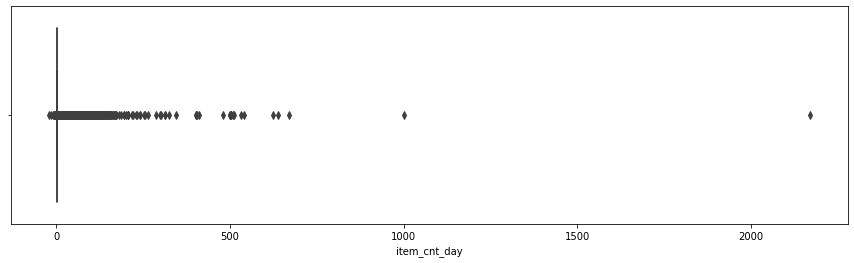

In [172]:
# 이상치 확인(2) - df_train.item_cnt_day
plt.figure(figsize=(15,4))
sns.boxplot(x=df_train.item_cnt_day)
print(df_train.item_cnt_day.max(), df_train.item_cnt_day.min(), sep='/')

In [173]:
# 이상치 확인(2-1) - 이상치로 예상되는 데이터 확인 - 450 이상
df_train[(df_train.item_cnt_day>=450)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1573253,2014-04-22,15,27,8057,1200.000000,502.0
1708207,2014-06-28,17,25,20949,5.000000,501.0
2048518,2014-10-02,21,12,9242,1500.000000,512.0
2067669,2014-10-09,21,55,19437,899.000000,508.0
2257299,2014-12-19,23,12,20949,4.000000,500.0
2326930,2015-01-15,24,12,20949,4.000000,1000.0
2608040,2015-04-14,27,12,3731,1904.548077,624.0
2625847,2015-05-19,28,12,10209,1499.000000,480.0
2626181,2015-05-19,28,12,11373,155.192950,539.0
2851073,2015-09-29,32,55,9249,1500.000000,533.0


In [174]:
num = [8057,20949,9242,19437,3731,10209,11373,9249,9248]
item_name = []
for i in num:
  item_name.append(df_items[df_items.item_id==i])
item_name = pd.DataFrame(np.array(item_name).reshape(len(item_name),-1))
item_name
# 순서대로 i tunes, 비닐봉투, 행사티켓, 게임, 게임, 게임, 배송서비스, 행사티켓, 행사티켓

,0,1,2
0,iTunes 1500 руб.,8057,32
1,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71
2,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",9242,8
3,"Средиземье: Тени Мордора [PC, Цифровая версия]",19437,31
4,"Grand Theft Auto V [PC, русские субтитры]",3731,30
5,"Ведьмак 3: Дикая охота [PC, русская версия]",10209,28
6,Доставка до пункта выдачи (Boxberry),11373,9
7,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",9249,8
8,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",9248,80


In [175]:
# i tunes의 경우 단순 행사로 인해 많이 판매된 것으로 판단
# 매년 이런 행사가 있지 않으므로 제거해야함
df_train[(df_train.item_id==8057)&(df_train.shop_id==27)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1130026,2013-12-28,11,27,8057,1500.0,1.0
1573252,2014-04-23,15,27,8057,1200.0,401.0
1573253,2014-04-22,15,27,8057,1200.0,502.0
1631422,2014-05-24,16,27,8057,1500.0,1.0
1709781,2014-06-02,17,27,8057,1500.0,1.0
1847640,2014-07-20,18,27,8057,1500.0,1.0
1847641,2014-07-04,18,27,8057,1500.0,1.0
1847642,2014-07-03,18,27,8057,1500.0,2.0
1952598,2014-08-29,19,27,8057,1500.0,1.0
1952599,2014-08-20,19,27,8057,1500.0,1.0


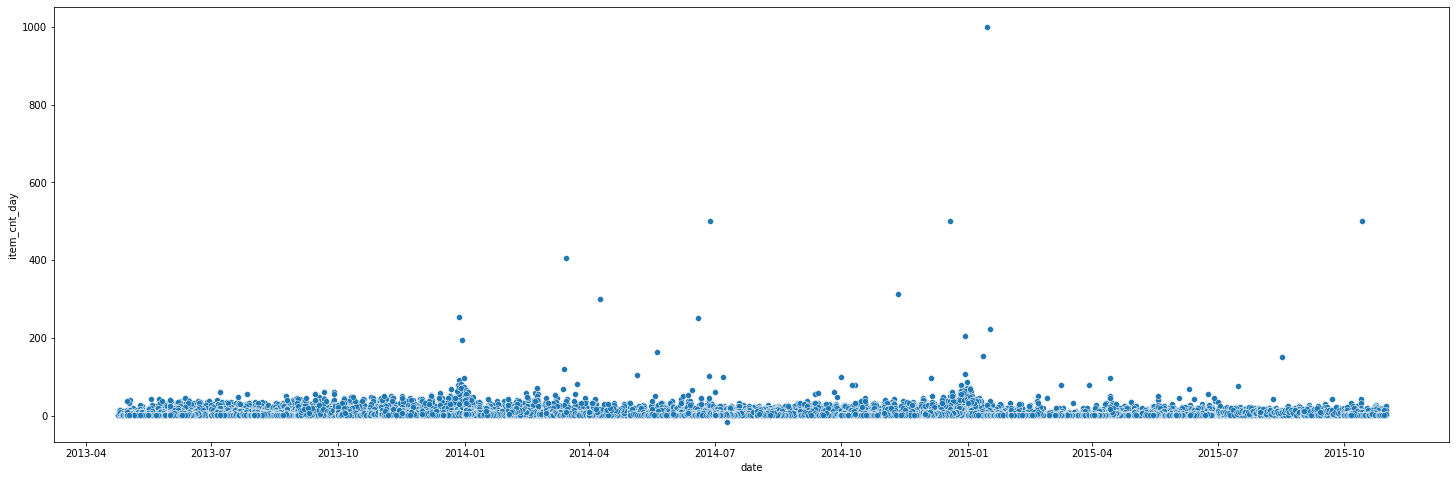

In [176]:
# 비닐봉투
# 상당수가 12번 매장
# 12번 매장은 해외배송을 하는 업체라고 판단했었음
# 비닐봉투 판매 추세를 확인
vinyl = df_train[(df_train.item_id==20949)]
plt.figure(figsize=(25,8))
sns.scatterplot(x='date', y='item_cnt_day', data=vinyl)
# plt.plot(vinyl.date, vinyl.item_cnt_day)
plt.show()
# 500 이상은 이상치로 판단 > 제거

In [177]:
# 행사티켓
# ИгроМир라는 행사의 티켓으로 2014년, 2015년 모두 특정 기간만 판매량이 높은 상품
# 2015년에는 이미 행사티켓이 판매되었고 10월 1-4일에 행사 진행되었음
# 따라서 해당 행사과 관련된 행 자체를 전부 삭제 처리

In [178]:
df_items[df_items['item_name'].str.contains('ИгроМир')]

,item_name,item_id,item_category_id
9241,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",9241,8
9242,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",9242,8
9243,"Билет ""ИгроМир 2014"" - семейный до 4-х человек...",9243,8
9244,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) [...",9244,80
9245,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) У...",9245,8
9246,"Билет ""ИгроМир 2015"" - 2 октября 2015 [Цифрова...",9246,80
9247,"Билет ""ИгроМир 2015"" - 2 октября 2015 УПР [Циф...",9247,8
9248,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",9248,80
9249,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",9249,8
9250,"Билет ""ИгроМир 2015"" - 3 октября 2015 [Цифрова...",9250,80


In [179]:
# 게임
# 게임의 경우 인기에 따라 판매량이 급등할 것이라고 판단
# 과거 2015년 11월 발매된 게임을 찾아 보았을 때, 충분히 판매량이 증가할 가능성이 존재함(스타크래프트2)
# 따라서 데이터 살리기로 판단

In [180]:
# 배송서비스
df_train[(df_train.date.dt.year==2015)&(df_train.date.dt.month==10)&(df_train.date.dt.day==28)&(df_train.shop_id==12)&~(df_train.item_id==11373)].item_cnt_day.sum()
# 당일 판매된 상품량은 배송서비스를 제외하면 90건
# 이전의 배송건이 있다하더라도 2000이넘는 수치는 비정상으로 판단
# 제거

90.0

In [181]:
# 이상치 처리(2-1) - item_cnt_day의 값이 450이상 인 행 중 게임을 제외하고 삭제
# 삭제할 데이터 확인
print(len(df_train[(df_train.item_cnt_day>=450)&~(df_train.item_id==19437)&~(df_train.item_id==3731)&~(df_train.item_id==10209)]))
df_train[(df_train.item_cnt_day>=450)&~(df_train.item_id==19437)&~(df_train.item_id==3731)&~(df_train.item_id==10209)]

12


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1573253,2014-04-22,15,27,8057,1200.000000,502.0
1708207,2014-06-28,17,25,20949,5.000000,501.0
2048518,2014-10-02,21,12,9242,1500.000000,512.0
2257299,2014-12-19,23,12,20949,4.000000,500.0
2326930,2015-01-15,24,12,20949,4.000000,1000.0
2626181,2015-05-19,28,12,11373,155.192950,539.0
2851073,2015-09-29,32,55,9249,1500.000000,533.0
2851091,2015-09-30,32,55,9249,1702.825746,637.0
2864235,2015-09-30,32,12,9248,1692.526158,669.0
2864260,2015-09-29,32,12,9248,1500.000000,504.0


In [182]:
# 인덱스를 이용해 해당 행 삭제
idx_list = df_train[(df_train.item_cnt_day>=450)&~(df_train.item_id==19437)&~(df_train.item_id==3731)&~(df_train.item_id==10209)].index
print(len(df_train))
df_train_drop = df_train.drop(idx_list)
print(len(df_train_drop))
df_train = df_train_drop
print(len(df_train))

2935845
2935833
2935833


In [183]:
# 이상치 확인(2-2) - item_cnt_day가 0 미만인 경우
df_train[(df_train.item_cnt_day<0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,2013-01-05,0,25,2552,899.0,-1.0
148,2013-01-23,0,25,2321,999.0,-1.0
175,2013-01-07,0,25,2199,1449.0,-1.0
807,2013-01-02,0,25,2330,599.0,-1.0
1041,2013-01-13,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1.0
2934462,2015-10-18,33,25,4896,6398.0,-1.0
2935263,2015-10-05,33,25,10039,249.0,-1.0
2935643,2015-10-16,33,25,7893,2990.0,-1.0


In [184]:
# 음수인 일일판매량 고유값 확인
df_train[(df_train.item_cnt_day<0)].item_cnt_day.unique()

array([ -1.,  -5.,  -6.,  -3.,  -2.,  -4., -22., -16.,  -9.])

In [185]:
# -22인 상품이 이전 얼마나 판매되었는지 확인
check_item_id = df_train[(df_train.item_cnt_day==-22)]['item_id'].iloc[0]
df_train[(df_train.item_id==check_item_id)&(df_train.date<='2013-11-02')]
# 동일한 매장에서 동일 상품이 동일 수량으로 판매된 이력이 존재
# 따라서 음수값은 환불을 의미하는 것으로 판단
# 동일 월 내에서 환불처리가 이루어졌다면, 단순히 해당 갯수들을 0으로 만들어 처리하겠지만, 구입 월과 환불 월이 다름
# 따라서 월별 판매량을 예상하는데에는 음수값을 그대로 이용하는 것이 옳다고 판단하고 따로 처리하지 않음

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
8820,2013-01-04,0,22,8023,20.0,1.0
11064,2013-01-02,0,19,8023,20.0,1.0
11065,2013-01-03,0,19,8023,20.0,1.0
11066,2013-01-06,0,19,8023,20.0,1.0
15486,2013-01-02,0,28,8023,20.0,1.0
...,...,...,...,...,...,...
870409,2013-09-28,8,6,8023,15.0,1.0
885224,2013-09-25,8,12,8023,15.0,22.0
902644,2013-09-08,8,27,8023,15.0,1.0
936805,2013-10-16,9,38,8023,15.0,1.0


In [186]:
# 이상치 확인(3) - 일일판매량의 단위가 소수점인 경우가 있는지 확인
df_train[(df_train.item_cnt_day % 1 != 0)]
# 없음

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [187]:
# 실수형일 필요가 없으므로 정수형으로 데이터타입 변환
df_train.item_cnt_day=df_train.item_cnt_day.astype('int')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935833 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 156.8 MB


# -------------------------------------shops---------------------------------------------

In [218]:
df_shops = pd.read_csv('/content/drive/MyDrive/Predict_future_sales/data/shops.csv')
# 데이터 확인
df_shops.head()
# 번역을 통해 살펴본 결과, 각 매장명의 첫 단어는 우리나라로 치면 시도명
# 두번째 단어는 쇼핑몰의 종류( ТЦ,ТРК 등)나 시군구명(Орджоникидзе) 등임
# 실제 매장의 이름은 shop_id로 인해 따로 속성을 추가할 필요가 없음
# 쇼핑몰의 종류나 시군구명은 모든 데이터에 동일하게 존재하지 않으므로 사용 불가
# 따라서 각 시도명을 추출

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [219]:
# 시도명 추출
df_shops['city'] = df_shops['shop_name'].str.split(' ').str[0]
df_shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [220]:
# 시도명 유일값 확인
df_shops['city'].unique()
# !Якутск와 Якутск이 따로 존재

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [221]:
# 중복 시도명 통합
print(len(df_shops.city))
for i in range(len(df_shops)):
  if df_shops.iloc[i,2] == '!Якутск':
    df_shops.iloc[i,2] = 'Якутск'   
print(len(df_shops.city), '\n')
print(df_shops['city'].unique())

60
60 

['Якутск' 'Адыгея' 'Балашиха' 'Волжский' 'Вологда' 'Воронеж' 'Выездная'
 'Жуковский' 'Интернет-магазин' 'Казань' 'Калуга' 'Коломна' 'Красноярск'
 'Курск' 'Москва' 'Мытищи' 'Н.Новгород' 'Новосибирск' 'Омск'
 'РостовНаДону' 'СПб' 'Самара' 'Сергиев' 'Сургут' 'Томск' 'Тюмень' 'Уфа'
 'Химки' 'Цифровой' 'Чехов' 'Ярославль']


In [222]:
# 이름이 차이가 나지 않는 데이터 확인
print(df_shops['shop_name'][0], df_shops['shop_name'][57], sep='----')
print(df_shops['shop_name'][1], df_shops['shop_name'][58], sep='----')
print(df_shops['shop_name'][10], df_shops['shop_name'][11], sep='----')
print(df_shops['shop_name'][39], df_shops['shop_name'][40], sep='----')
# 다른 매장인지 추가 확인 필요

!Якутск Орджоникидзе, 56 фран----Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран----Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м?----Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт"----РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [223]:
df_train[df_train.shop_id==0].sort_values(by='date')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
43384,2013-01-03,0,0,18826,205.0,1
43431,2013-01-03,0,0,19064,578.0,1
41184,2013-01-03,0,0,5591,1556.0,1
44102,2013-01-03,0,0,17560,247.0,1
40556,2013-01-03,0,0,5629,1925.0,1
...,...,...,...,...,...,...
181793,2013-02-28,1,0,7234,378.0,1
174967,2013-02-28,1,0,1522,1313.0,1
179384,2013-02-28,1,0,18661,27.0,1
174940,2013-02-28,1,0,1833,1589.0,2


In [224]:
df_train[df_train.shop_id==57].sort_values(by='date')
# 정확하게 앞에 매장 판매일 이후부터 다음매장 데이터가 존재 > 같은 매장이지만 입력오류일것

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
260891,2013-03-01,2,57,257,249.0,1
260669,2013-03-01,2,57,1398,599.0,1
341018,2013-03-01,2,57,6490,349.5,1
338130,2013-03-01,2,57,18164,349.0,2
341017,2013-03-01,2,57,6478,199.5,1
...,...,...,...,...,...,...
2895733,2015-10-31,33,57,7780,198.0,1
2899878,2015-10-31,33,57,17772,999.0,1
2901029,2015-10-31,33,57,18719,49.0,1
2895305,2015-10-31,33,57,1584,3999.0,1


In [225]:
# 나머지도 확인
print(df_train[df_train.shop_id==1].date.max(), df_train[df_train.shop_id==58].date.min())
print(df_train[df_train.shop_id==10].date.max(), df_train[df_train.shop_id==11].date.min())
print(df_train[df_train.shop_id==39].date.max(), df_train[df_train.shop_id==40].date.min())
# 1,58의 경우는 위와 동일했으나, 10,11과 39,40은 동일하지 않음 > 추가적으로 확인

2013-02-28 00:00:00 2013-03-01 00:00:00
2015-10-31 00:00:00 2015-02-01 00:00:00
2015-10-31 00:00:00 2014-03-01 00:00:00


In [226]:
print(df_train[(df_train.shop_id==11)])
print(df_train[(df_train.shop_id==10)&(df_train.date>'2015-02-01')])
# 2월달 데이터만 따로 빠져나온것 > 같은 매장임 > 11이 10으로 통합되야함

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2461045 2015-02-27              25       11    22162      237.11             1
2461046 2015-02-23              25       11    22162      237.11             1
2461047 2015-02-20              25       11    22162      270.00             1
2461048 2015-02-11              25       11    22162      270.00             1
2461049 2015-02-10              25       11    22162      270.00             1
...            ...             ...      ...      ...         ...           ...
2462003 2015-02-12              25       11    10389      219.00             1
2462004 2015-02-07              25       11    10382      460.00             1
2462005 2015-02-17              25       11    10379      195.00             1
2462006 2015-02-18              25       11    10298       99.00             1
2462007 2015-02-02              25       11    10518      295.00             1

[499 rows x 6 columns]
              date  date_blo

In [227]:
print(df_train[df_train.shop_id==39].date.max(), df_train[df_train.shop_id==40].date.max())
print(df_train[df_train.shop_id==39].date.min(), df_train[df_train.shop_id==40].date.min())
print(df_train[(df_train.shop_id==39)&(df_train.date=='2014-03-01')],'\n')
print(df_train[(df_train.shop_id==40)&(df_train.date=='2014-03-01')])
# 같은 매장이라고 보기 힘듬, 다만 40번매장은 문을 닫았을 것으로 판단됨
# 폐점 여부가 필요한 속성인가? > 예측값이 매장별/아이템별 한달 판매량이므로 폐장한 매장이라면 예측값이 0이어야함 > 따라서 의미있다고 판단

2015-10-31 00:00:00 2015-01-29 00:00:00
2014-03-01 00:00:00 2014-03-01 00:00:00
              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
1530407 2014-03-01              14       39      934       399.0             1
1530416 2014-03-01              14       39     1459      1199.0             1
1530418 2014-03-01              14       39     2308       299.0             1
1530438 2014-03-01              14       39     1511       799.0             1
1530755 2014-03-01              14       39     7213       899.0             1
1530756 2014-03-01              14       39     7207       199.0             1
1530758 2014-03-01              14       39     7206       199.0             1
1530797 2014-03-01              14       39     7736       299.0             2
1530829 2014-03-01              14       39     6185       499.0             1
1530841 2014-03-01              14       39     7004       999.0             1
1530844 2014-03-01              14       39     700

In [237]:
# 잘못 입력된 걸로 판단되는 매장의 id 통합
df_train['shop_id'].replace(0,57,inplace=True)
df_train['shop_id'].replace(1,58,inplace=True)
df_train['shop_id'].replace(11,10,inplace=True)

df_test['shop_id'].replace(0,57,inplace=True)
df_test['shop_id'].replace(1,58,inplace=True)
df_test['shop_id'].replace(11,10,inplace=True)
df_train['shop_id'].unique(), df_test['shop_id'].unique()

(array([59, 25, 24, 23, 19, 22, 18, 21, 28, 27, 29, 26,  4,  6,  2,  3,  7,
        57, 58, 16, 15,  8, 10, 14, 13, 12, 53, 31, 30, 32, 35, 56, 54, 47,
        50, 42, 43, 52, 51, 41, 38, 44, 37, 46, 45,  5, 55, 17,  9, 49, 39,
        40, 48, 34, 33, 20, 36]),
 array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
        18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
        35, 38, 34, 46, 41, 44, 39, 45]))

In [240]:
# 폐점 매장 여부 확인 - 판매이력이 2015년 6월부터 없는 경우
for i in df_train['shop_id'].unique():
  if df_train[df_train.shop_id==i].date.max() < pd.Timestamp(2015, 6, 1):
    print(i,df_train[df_train.shop_id==i].date.max())

# 테스트 데이터에서 이미 다 제외됨 > 따라서 폐점 여부 속성 추가는 불필요
# 예측해야하는 신규매장은?

23 2013-04-28 00:00:00
29 2015-05-28 00:00:00
8 2013-04-01 00:00:00
13 2014-08-09 00:00:00
30 2015-02-18 00:00:00
32 2013-07-03 00:00:00
54 2015-04-23 00:00:00
43 2015-01-25 00:00:00
17 2015-01-18 00:00:00
40 2015-01-29 00:00:00
33 2015-04-24 00:00:00


In [256]:
train_shop_id = sorted(list(df_train['shop_id'].unique()))
test_shop_id = sorted(list(df_test['shop_id'].unique()))
print(train_shop_id)
print(test_shop_id)
# 신규매장 없음, 학습 데이터에서 예측하지 않아도 되는 매장의 데이터는 필요없다고 판단

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59]


In [258]:
# 예측에 불필요한 매장 데이터 제거
print(df_train)
df_train = df_train[df_train['shop_id'].isin(df_test['shop_id'].unique())]
print(df_train)

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0       2013-01-02               0       59    22154      999.00             1
1       2013-01-03               0       25     2552      899.00             1
2       2013-01-05               0       25     2552      899.00            -1
3       2013-01-06               0       25     2554     1709.05             1
4       2013-01-15               0       25     2555     1099.00             1
...            ...             ...      ...      ...         ...           ...
2935844 2015-10-10              33       25     7409      299.00             1
2935845 2015-10-09              33       25     7460      299.00             1
2935846 2015-10-14              33       25     7459      349.00             1
2935847 2015-10-22              33       25     7440      299.00             1
2935848 2015-10-03              33       25     7460      299.00             1

[2935833 rows x 6 columns]
              date  date

In [135]:
# 각 시도별 위경도 데이터활용 위치 확인
# 구글 지도 활용
# 외부데이터 제한에 대한 competition rule 없음

In [259]:
df_latlong = pd.read_excel('/content/drive/MyDrive/Predict_future_sales/data/latlong.xlsx')
df_latlong.columns=['city','latlong']
df_latlong['lat']=df_latlong['latlong'].str.split(',').str[0]
df_latlong['long']=df_latlong['latlong'].str.split(',').str[1]

In [260]:
df_latlong.dropna(inplace=True)
df_latlong.drop('latlong',axis=1,inplace=True)
df_latlong['lat']=df_latlong['lat'].astype('float')
df_latlong['long']=df_latlong['long'].astype('float')
df_latlong.head()

,city,lat,long
0,Адыгея,44.488691,39.166305
1,Балашиха,55.768381,37.922410
2,Волжский,48.818396,44.686841
3,Вологда,59.222198,39.805926
4,Воронеж,51.699929,39.052987


In [261]:
map = folium.Map(location = [55.5815245,36.8251381],tiles = 'StamenTerrain', zoom_start = 11)

for idx in df_latlong.index:
  lat = df_latlong.loc[idx, 'lat']
  lng = df_latlong.loc[idx, 'long']
  city = df_latlong.loc[idx, 'city']
  
  folium.Marker(location = [lat,lng]).add_to(map)

map
# 도시를 크게 묶을 만큼 군집이 형성되지 않으므로 도시명 자체로 라벨 인코딩 진행

In [262]:
# 도시명 라벨 인코딩
df_shops['city_label']=LabelEncoder().fit_transform(df_shops.city)
df_shops_label = df_shops.drop(['shop_name','city'],axis=1)
df_shops_label.head()

,shop_id,city_label
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


# -------------------------------------item_categories---------------------------------------------

In [263]:
df_item_categories.head(10)
# -를 기준으로 대분류-소분류로 데이터가 존재
# 각 대분류와 소분류에 대해 라벨 인코딩 진행

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [264]:
# 대분류/소분류 컬럼 생성
df_item_categories['main_cat'] = df_item_categories['item_category_name'].str.split(' - ').str[0].str.strip()
df_item_categories['sub_cat'] = df_item_categories['item_category_name'].str.split(' - ').str[1].str.strip()
df_item_categories.head(10)

,item_category_name,item_category_id,main_cat,sub_cat
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP
5,Аксессуары - PSVita,5,Аксессуары,PSVita
6,Аксессуары - XBOX 360,6,Аксессуары,XBOX 360
7,Аксессуары - XBOX ONE,7,Аксессуары,XBOX ONE
8,Билеты (Цифра),8,Билеты (Цифра),NaN
9,Доставка товара,9,Доставка товара,NaN


In [266]:
df_item_categories.info()
# 12개 항목에 대해 소분류 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
 2   main_cat            84 non-null     object
 3   sub_cat             77 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.8+ KB


In [268]:
# 소분류 NaN을 etc로 대체
df_item_categories.fillna('etc', inplace=True)

In [142]:
# # 소분류 NaN값의 경우, 대분류와 동일한 것으로 변경
# df_item_categories = df_item_categories.fillna(method='ffill',axis=1)
# df_item_categories.head(10)

,item_category_name,item_category_id,main_cat,sub_cat
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP
5,Аксессуары - PSVita,5,Аксессуары,PSVita
6,Аксессуары - XBOX 360,6,Аксессуары,XBOX 360
7,Аксессуары - XBOX ONE,7,Аксессуары,XBOX ONE
8,Билеты (Цифра),8,Билеты (Цифра),Билеты (Цифра)
9,Доставка товара,9,Доставка товара,Доставка товара


In [269]:
# 대분류와 소분류 라벨 인코딩, 필요없는 컬럼 제거
df_item_categories['main_cat']=LabelEncoder().fit_transform(df_item_categories['main_cat'])
df_item_categories['sub_cat']=LabelEncoder().fit_transform(df_item_categories['sub_cat'])
df_item_categories_label = df_item_categories.drop('item_category_name',axis=1)
df_item_categories_label.head()

,item_category_id,main_cat,sub_cat
0,0,0,31
1,1,1,11
2,2,1,12
3,3,1,13
4,4,1,15


# --------------------------------items-------------------------------------



In [271]:
df_items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [273]:
# 단종된 상품의 경우, 예측값=0?
# 신상품(트레인에 없고 테스트에만 있는)은?

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


# -------------------------------------item  별/ 월별 판매량 피벗테이블(아직 어떻게 쓸지 생각안함)---------------------------------------------

In [144]:
cnt_item_month = df_train.pivot_table(index='item_id',values='item_cnt_day', columns='date_block_num', aggfunc='sum', fill_value=0).reset_index()
cnt_item_month.columns.name = None
cnt_item_month

,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21799,22165,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
21800,22166,0,0,0,0,0,0,0,0,0,...,7,8,12,4,8,10,8,11,5,11
21801,22167,0,0,0,0,0,0,0,0,56,...,33,46,40,38,31,33,34,29,21,37
21802,22168,2,2,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


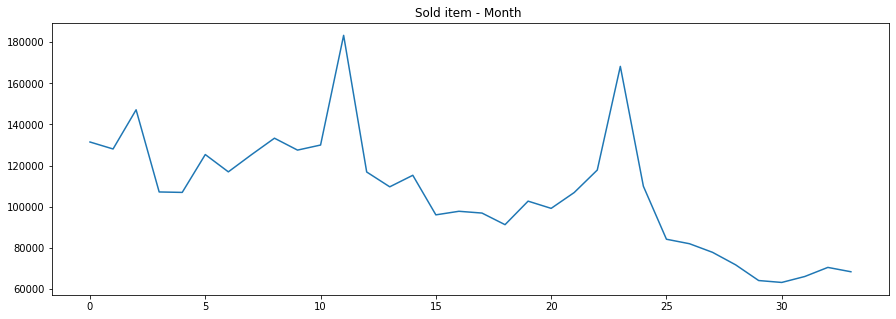

In [282]:
cnt_month = cnt_item_month.drop('item_id', axis=1).sum(axis=0)

plt.figure(figsize=(15,5))
plt.plot(cnt_month)
plt.title('Sold item - Month ')
plt.show()

In [ ]:
# 특정 기간 판매량 급증
# 전체적으로는 하락 추세